# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

RESPONSE_VAR = 'temperature'

%matplotlib inline

In [2]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


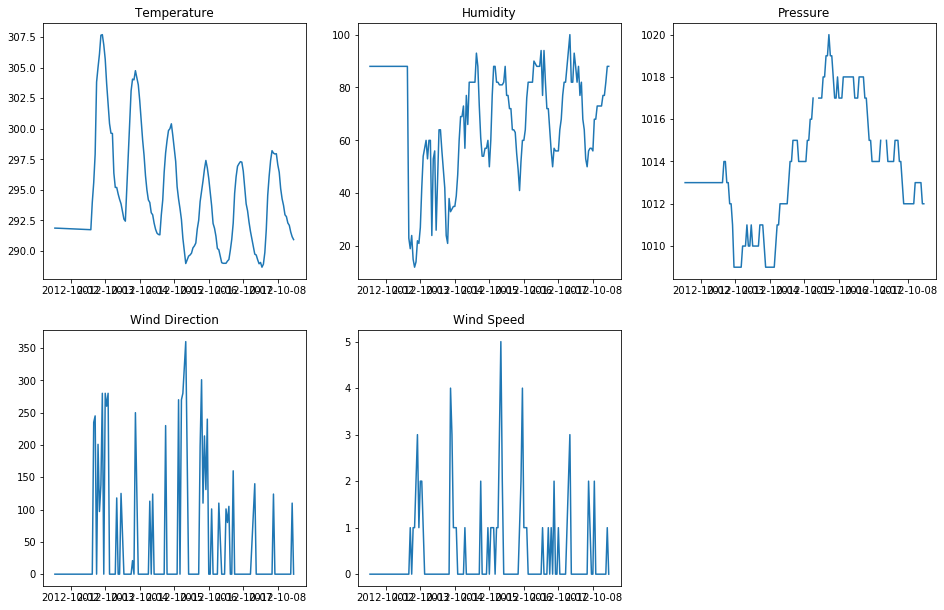

In [3]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [4]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [5]:
252 / df.shape[0]

0.0055686915784588864

In [6]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [7]:
# Convert date col to numeric representation.
df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)


noisy_test_df = test_df.copy()

In [8]:
noisy_test_df['temperature'].isna().sum()

0

In [9]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False)

In [10]:
noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

In [11]:
noisy_test_df['temperature'].isna().sum()

905

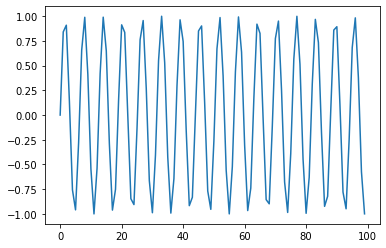

In [12]:
plt.plot(np.arange(noisy_test_df[:100].shape[0]), np.sin(np.arange(noisy_test_df[:100].shape[0])))

# plt.plot(np.arange(100), )

In [13]:
# generate a range of vals (0 ... n_rows)
idxs = np.arange(noisy_test_df.shape[0])
# generate a sin wave onto range
noisy_test_df_sin = np.sin(idxs) ** 2
# use sum as denominator to make the sin vals total to 1.
sum_idxs = np.sum(noisy_test_df_sin)

prob = noisy_test_df_sin / sum_idxs
# check the sum of sin's totals to 1.
assert int(np.sum(prob)) == 1

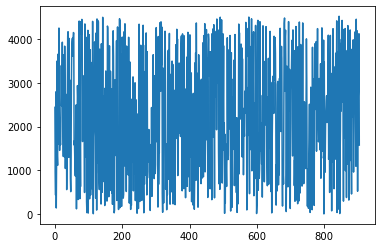

In [14]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False, p=prob)

plt.plot(gap_indxs)

In [15]:
noisy_test_df = test_df.copy()

noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

#### Plotting Noisy Data

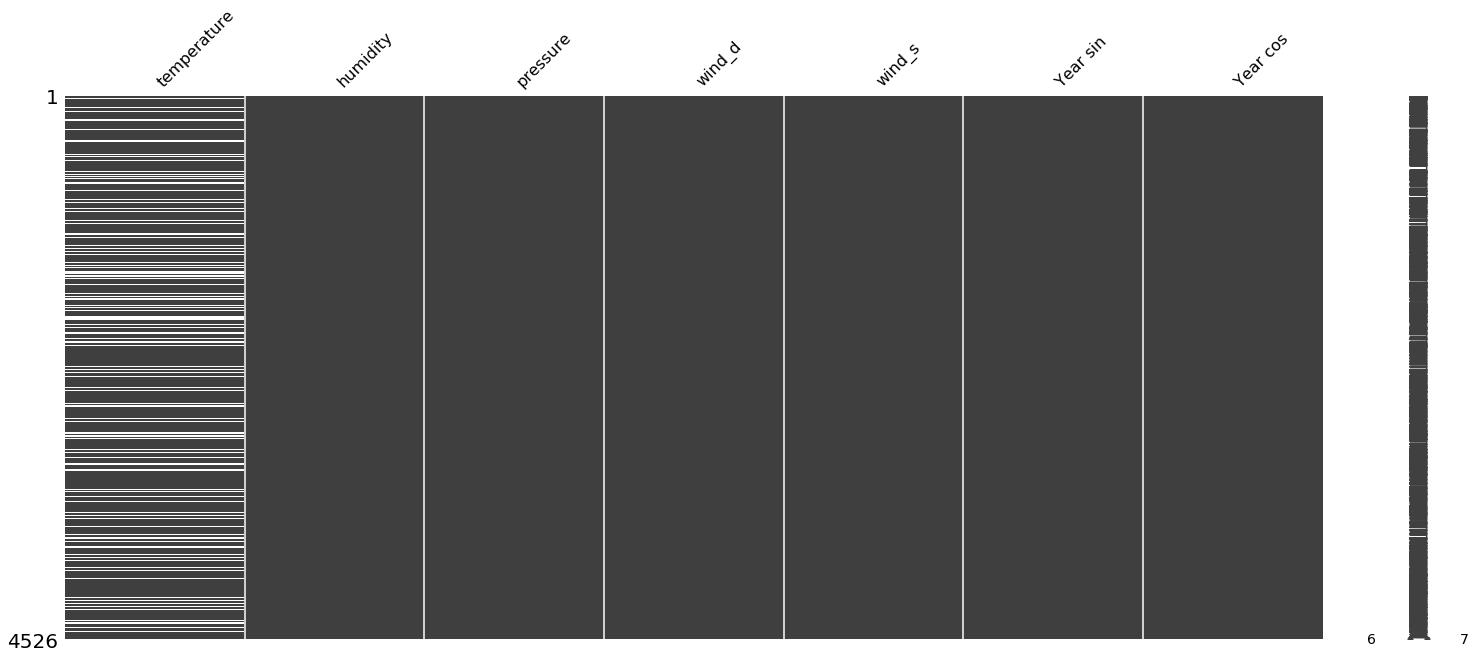

In [16]:
import missingno as msno

msno.matrix(noisy_test_df);

In [21]:
temp_int

40727    288.73
40728    288.73
40729    288.56
40730    288.65
40731    288.98
          ...  
45248    293.55
45249    295.68
45250    295.96
45251    295.65
45252       NaN
Name: temperature, Length: 4526, dtype: float64

In [20]:
np.isnan(test_df['temperature']).sum(),np.isnan(temp_int).sum()

(0, 1)

In [22]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

mses = []

for method in methods:
    order = 2
    temp_int = noisy_test_df['temperature'].interpolate(method=method, order=order)
    # fill if method creates NA val
    temp_int = temp_int.fillna(method='bfill').fillna(method='ffill')
    mse = mean_squared_error(test_df['temperature'], temp_int)

    mses.append(mse)

In [23]:
pd.DataFrame({"method": methods, "MSE": mses}).sort_values(by='MSE', ascending=True)

,method,MSE
13,akima,0.052212
12,pchip,0.053770
6,quadratic,0.058455
9,polynomial,0.058455
7,cubic,0.059855
14,cubicspline,0.061089
10,piecewise_polynomial,0.062546
15,from_derivatives,0.062546
0,linear,0.062546
1,index,0.062546


## Linear Model

In [24]:
train_df.dtypes

temperature    float64
humidity       float64
pressure       float64
wind_d         float64
wind_s         float64
Year sin       float64
Year cos       float64
dtype: object

In [25]:
train_df, val_df, test_df = split_df(df)

# num_features = df.shape[1]

train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, dependent=RESPONSE_VAR)

#### Windowing data

In [31]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [32]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, wide_window)

Epoch 1/20
990/990 [==============================] - 1s 1ms/step - loss: 88.1877 - mean_absolute_error: 4.7067 - mean_absolute_percentage_error: 1.6212 - val_loss: 3.2199 - val_mean_absolute_error: 1.2386 - val_mean_absolute_percentage_error: 0.4244
Epoch 2/20
990/990 [==============================] - 1s 1ms/step - loss: 3.2060 - mean_absolute_error: 1.2757 - mean_absolute_percentage_error: 0.4395 - val_loss: 2.5193 - val_mean_absolute_error: 1.0314 - val_mean_absolute_percentage_error: 0.3530
Epoch 3/20
990/990 [==============================] - 1s 1ms/step - loss: 2.8423 - mean_absolute_error: 1.1751 - mean_absolute_percentage_error: 0.4049 - val_loss: 2.3052 - val_mean_absolute_error: 0.9646 - val_mean_absolute_percentage_error: 0.3298
Epoch 4/20
990/990 [==============================] - 1s 1ms/step - loss: 2.7524 - mean_absolute_error: 1.1524 - mean_absolute_percentage_error: 0.3970 - val_loss: 2.3067 - val_mean_absolute_error: 0.9769 - val_mean_absolute_percentage_error: 0.3340

In [33]:
wide_window.test_df[:7]

,temperature,humidity,pressure,wind_d,wind_s,Year sin,Year cos
40727,288.73,0.081420,-0.822047,1.205877,-0.026447,0.808989,-1.254875
40728,288.48,0.949324,-0.822047,1.301043,1.530699,0.808191,-1.255500
40729,288.56,0.264136,-0.822047,-1.268448,-0.026447,0.807393,-1.256125
40730,288.65,0.492532,-0.822047,0.920378,-0.026447,0.806594,-1.256749
40731,288.98,0.264136,-0.707277,-1.268448,0.752126,0.805794,-1.257373
40732,289.09,0.081420,-0.707277,0.444546,0.752126,0.804994,-1.257996
40733,289.66,0.081420,-0.707277,-1.268448,1.530699,0.804194,-1.258618


In [99]:
preds = linear.predict(wide_window.test_df[nan_indx - 7: nan_indx])

preds

array([[288.94873],
       [288.5026 ],
       [289.38605],
       [289.05954],
       [290.06036],
       [290.17853],
       [290.5154 ]], dtype=float32)

In [87]:
mean_squared_error(preds, test_df)

TypeError: 'numpy.float64' object is not callable

### Convert Predictions into Interpolation Function
- find nans indexes 
- get preceeding 7 indexes for nan indexes, if index < 7 => interpolate with conventional method
- feed 7 size window to model
- merge prediction into noisy dataframe

In [129]:
noisy_test_df.iloc[:7] = noisy_test_df.iloc[:7].interpolate(method='akima')

noisy_test_array = noisy_test_df['temperature'].to_numpy()

# get indexs of nan values, index to 0th dimension (ugly)
nan_indxs = np.where(np.isnan(noisy_test_array))[0]

# nan_indx = nan_indxs[0]

for nan_indx in nan_indxs:
    preds = linear.predict(wide_window.test_df[nan_indx - 7: nan_indx])
    noisy_test_array = np.insert(noisy_test_array, nan_indx, preds[-1])

In [128]:
# for nan_indx in nan_indxs: print(nan_indx)
wide_window.test_df[11 - 7: 11]

,temperature,humidity,pressure,wind_d,wind_s,Year sin,Year cos
40731,288.98,0.264136,-0.707277,-1.268448,0.752126,0.805794,-1.257373
40732,289.09,0.081420,-0.707277,0.444546,0.752126,0.804994,-1.257996
40733,289.66,0.081420,-0.707277,-1.268448,1.530699,0.804194,-1.258618
40734,290.23,0.081420,-0.707277,0.539712,1.530699,0.803394,-1.259240
40735,290.66,0.264136,-0.592508,1.015544,2.309272,0.802592,-1.259861
40736,291.02,0.264136,-0.592508,0.730045,3.087845,0.801791,-1.260482
40737,291.65,0.081420,-0.592508,1.015544,0.752126,0.800989,-1.261102


In [130]:
np.insert(noisy_test_array, 9, preds[-1])[:10]

array([288.73      , 288.645     , 288.56      , 288.65      ,
       288.98      , 289.32      , 289.66      , 290.23      ,
       290.66      , 295.39477539])

In [133]:
nan_indxs[:10]

array([ 9, 10, 14, 17, 21, 24, 26, 27, 29, 33])

In [134]:
np.where(np.isnan(noisy_test_array))[0][:10]

array([11, 12, 18, 22, 30, 34, 38, 40, 42, 46])

In [120]:
np.isnan(noisy_test_array).sum()

903

In [104]:
noisy_test_df['temperature'].shape

(4526,)

In [105]:
preds[-1]

array([290.5154], dtype=float32)

array([288.73 , 288.645, 288.56 , ..., 295.96 , 295.65 ,     nan])

In [97]:
nan_indx - 7

2

In [98]:
noisy_test_df['temperature'].iloc[nan_indx - 7: nan_indx]

40729    288.56
40730    288.65
40731    288.98
40732    289.32
40733    289.66
40734    290.23
40735    290.66
Name: temperature, dtype: float64